In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import argparse
import sys
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
from influence import Influence
from mnist_models import Model
from utils import corrupt_mnist, Dataset, leave_one_out_dataset
from IPython.display import clear_output

np.random.seed(1)

FLAGS = None

# Import data
mnist = corrupt_mnist(input_data.read_data_sets("mnist_data", one_hot=True), 0.0)

testset = Dataset( (mnist.test.images, mnist.test.labels) )
trainset = Dataset ((mnist.train.images, mnist.train.labels) )

sess = tf.InteractiveSession()
model = Model("convnet", trainset, testset, sess)

saver = tf.train.Saver()

tf.global_variables_initializer().run()

summary_writter = tf.summary.FileWriter("./Hvp_summaries", sess.graph)

checkpoint_file = "/home/cgel/deep_quad/checkpoints/convnet.ckpt"

load = True
save = False
if not load:
    model.train(vervose=2)
    if save == True:
        saver.save(sess, checkpoint_file)
else:
    saver.restore(sess, checkpoint_file)

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


In [2]:
scale = float(len(trainset.labels)) * 10
inf = Influence(model.cross_entropy, testset, model.cross_entropy, trainset, model.input_ph, model.y_, scale, cg_iters = 100, dampening=0.0001, vervose=1)

In [ ]:
load_s = False
if load_s:
    inf.load_s("s_cache")
else:
    inf.compute_s()

Initial error: 2884.82037105


In [4]:
# compute the influences for every image in the training set
trainset_influence_map = []
trainset_influence = []
for i in range(len(mnist.train.labels)):
    z = (mnist.train.images[i:i+1], mnist.train.labels[i:i+1])
    influ, z_grad = inf.of_and_g(z)
    trainset_influence.append(influ*scale)
    trainset_influence_map.append( (influ, i))
    if i % 10000==0:
        print(i)

0
10000
20000
30000
40000
50000


In [5]:
# generate a list ordering the examples of the training set by most influential
abs_influence = []
for i_influence, i in trainset_influence_map:
    abs_influence.append((abs(i_influence), i))
abs_influence.sort(reverse=True)
rank = []
for i in range(len(trainset_influence_map)):
    j = abs_influence[i][1]
    rank.append( (trainset_influence[j], j) )

In [ ]:
influence_acc = []
grads_l = []
infs = []
d_losses = []

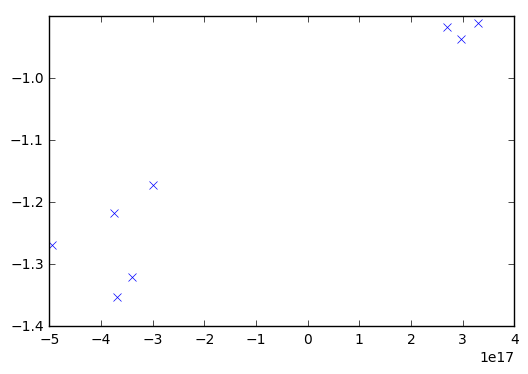

In [ ]:
# leave one out retraining 
subset = rank[0:20]
saver.restore(sess, checkpoint_file)
base_testset_loss = model.testset_loss()
for _,i in subset:
    z = (trainset.images[i:i+1], trainset.labels[i:i+1])
    z_influ, z_grad = inf.of_and_g(z)
    grads_l.append(z_grad*scale)
    model.trainset = leave_one_out_dataset(trainset, i)
    model.update(10000, learning_rate=1e-7)
    d_loss = base_testset_loss - model.testset_loss()
    print(i, ":  ", z_influ * scale, d_loss)
    influence_acc.append( (z_influ * scale, d_loss) )
    infs.append(z_influ * scale )
    d_losses.append(d_loss)
    saver.restore(sess, checkpoint_file)
    clear_output()
    plt.plot(infs, d_losses, "x")
    plt.show()
    
model.trainset = trainset

In [ ]:
plt.hist(trainset_influence, 100);

In [35]:
sorted_influence = sorted(trainset_influence, reverse=True)

In [43]:
ns = [10, 100, 1000, 10000, 30000, 50000]
for n in ns:
    r = sum([ r for r in sorted_influence[0:n] ])/sum(trainset_influence)
    print("%f%% of influence coming from %f%% of the images"%(r*100, n/len(trainset_influence) * 100))

-1.634319% of influence coming from 0.018182% of the images
-8.933251% of influence coming from 0.181818% of the images
-34.140337% of influence coming from 1.818182% of the images
-36.386229% of influence coming from 18.181818% of the images
-0.082451% of influence coming from 54.545455% of the images
36.834958% of influence coming from 90.909091% of the images


In [ ]:
influences_corrupted = []
influences_non_corrupted = []
grads_corrupted = []
grads_non_corrupted = []
#size = len(mnist.train.labels)
size = 1000
for i in range(size):
    z = (mnist.train.images[i:i+1], mnist.train.labels[i:i+1])
    influ, z_grad = inf.of_and_g(z)
    if mnist.train.corrupted_mask[i]:
        influences_corrupted.append(influ)
        grads_corrupted.append(z_grad)
    else:
        influences_non_corrupted.append(influ)
        grads_non_corrupted.append(z_grad)
all_influences = influences_corrupted + influences_non_corrupted
all_grads = grads_corrupted + grads_non_corrupted

In [83]:
print("non corrupted")
print("mean",np.mean( influences_non_corrupted))
print("std",np.std( influences_non_corrupted))

non corrupted
mean -6.47728385977e-08
std 1.21111189844e-05


In [84]:
print("corrupted")
print("mean",np.mean( influences_corrupted))
print("std",np.std( influences_corrupted))

corrupted
mean -1.88751401152e-06
std 5.31467498935e-06


In [16]:
inf.s = influence.lset(inf.s, 1.)

In [80]:
infs = []
d_losses = []
print("influence", "d_loss")
for pair in influence_acc:
    infs.append(pair[0])
    d_losses.append(pair[1])
    print(pair[0], pair[1])
    
plt.plot(infs, d_losses, "x")

influence d_loss
-3.42001894873 -12.5903
-3.42991299808 -12.5177
-3.31551817139 -12.4698
-3.1845451764 -12.823
-2.89722035186 -12.8751


In [39]:
influence_acc
cu = 0
for i in range(len(influence_acc)):
    print(influence_acc[i], mnist.train.corrupted_mask[i])
    cu += influence_acc[i][1]

(-0.027689653809073733, -12.173828) False
(2.253888293622941, -12.064087) False
(-0.057892054706257245, -12.17627) True
(-0.028630717219882418, -12.174316) False
(-0.015116766469772114, -12.174805) False
(0.017373136347864637, -12.154297) False
(-0.027889592524935058, -12.174683) False
(-0.028365732707147373, -12.173828) False
(-0.028661911857935651, -12.174316) False
(-0.032132640476745244, -12.174683) False
(0.42866204244207395, -12.179932) False
(-0.029064536376452454, -12.174072) False
(-0.16695554828166648, -12.234497) False
(-0.094426384465995383, -12.169678) False
(-0.099014407147698935, -12.190796) True
(0.053566588407716331, -12.184204) False
(-0.053189263293645928, -12.175903) False
(-0.028707009974843212, -12.174072) False
(-0.02871165062694192, -12.174072) False
(-0.029057295559478669, -12.173828) False
(-0.028698393551712664, -12.174194) False
(0.0093212496818373403, -12.175415) False
(-0.031820806585119987, -12.175049) False
(-0.031968775614441003, -12.173096) False
(-0.1